<a href="https://colab.research.google.com/github/sjkchang/CMPE255-Assignment3/blob/master/CRISP_DM_MachineFailureClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Understanding


**Business Problem**

The failure of a machine in a production or operational environment can have detrimental effects on a company. Such failures can lead to production downtime, resulting in significant revenue loss, increased maintenance costs, potential safety hazards, and negative impacts on company reputation. Therefore, predicting machine failures proactively becomes a critical task. Using the provided training and testing datasets, our aim is to develop a predictive model that can accurately determine whether a machine will fail or not, enabling the company to take preventive measures, optimize maintenance schedules, and ultimately save costs and ensure smooth operations.

 **Determine business objectives**


Our primary objective is to achieve the highest accuracy possible while minimizing false positives and false negatives. The reason being, predicting a machine won't fail when it actually will can lead to severe consequences, and predicting a machine will fail when it won't can result in unnecessary maintenance costs. We aim to provide the company with a reliable tool that can help in making informed decisions regarding machinery maintenance.

# Data understanding

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Datasets/255-Datasets/machine-failure
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Datasets/255-Datasets/machine-failure
sample_submission.csv  test.csv  train.csv


In [2]:
import pandas as pd

# Load the training dataset
train_data = pd.read_csv("train.csv")

# Display the first few rows of the training dataset
train_data.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


We can see that the data provides details about the operational parameters of the machine, the type of product it's working on, and specific reasons for machine failure.

    id: An identifier for each record.
    Product ID: Identifier for the product being produced.
    Type: Type of the product.
    Air temperature [K]: Temperature of the surrounding air.
    Process temperature [K]: Temperature of the operational process.
    Rotational speed [rpm]: Speed at which the machine is operating.
    Torque [Nm]: Torque produced by the machine.
    Tool wear [min]: Duration the tool has been in use without replacement.
    Machine failure: Binary value indicating if the machine failed (1) or not (0).
    TWF: Tool wear failure (binary: 1 if tool wear caused the failure, else 0).
    HDF: Heat dissipation failure (binary: 1 if heat caused the failure, else 0).
    PWF: Power failure (binary: 1 if power issues caused the failure, else 0).
    OSF: Overstrain failure (binary: 1 if overstrain caused the failure, else 0).
    RNF: Random failure (binary: 1 if the cause was random/unknown, else 0).

**Data Visualization**

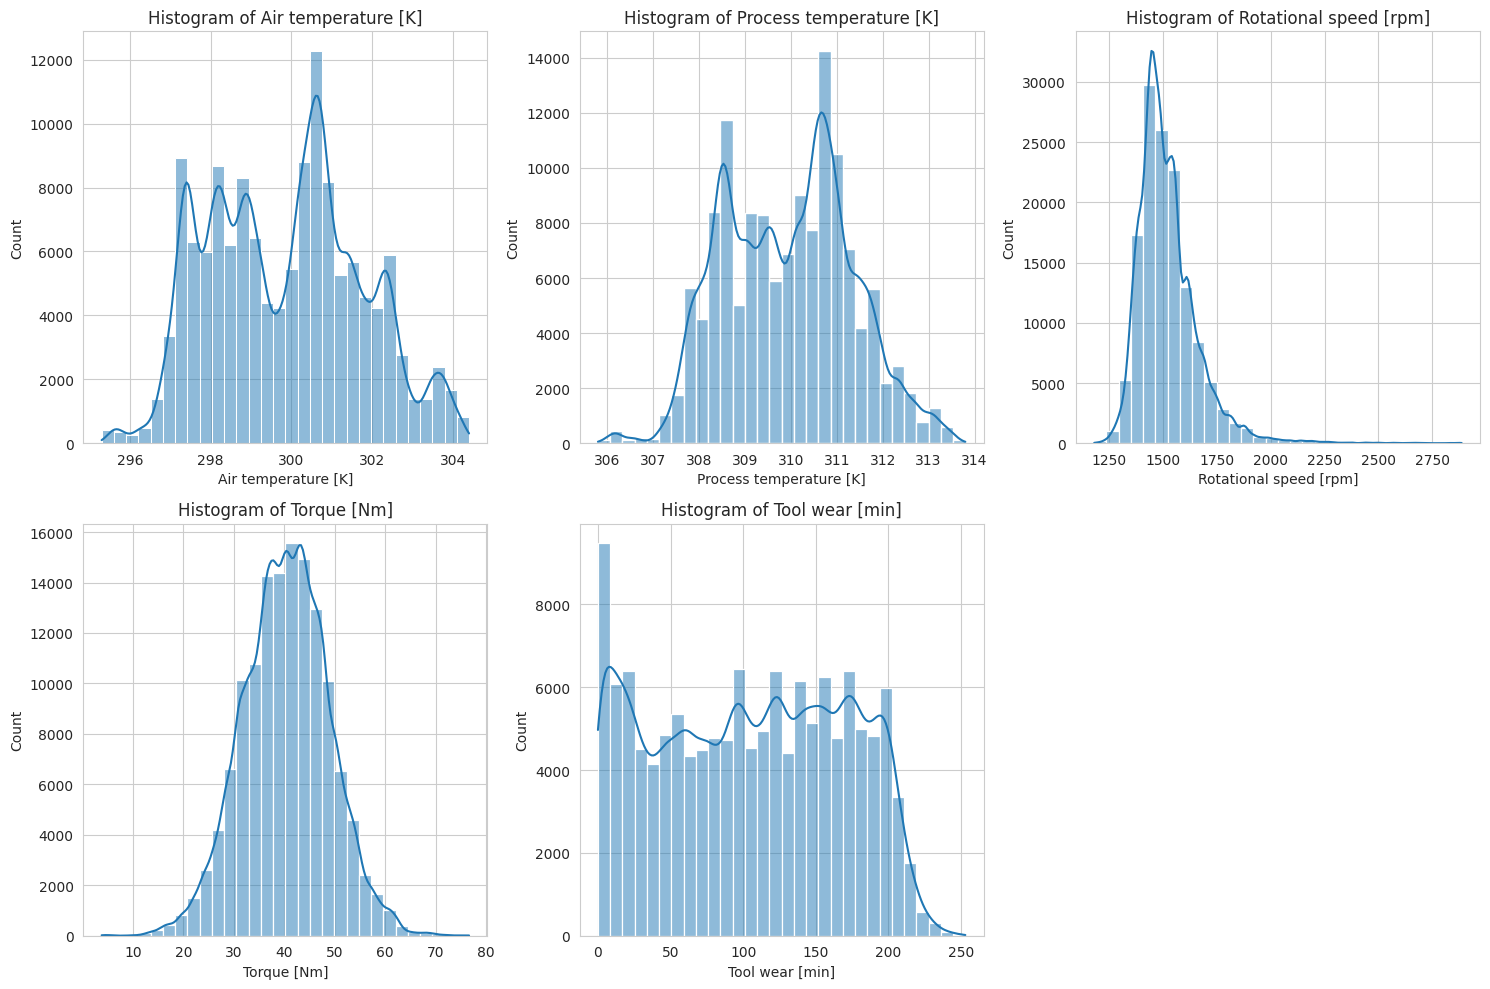

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for the visualizations
sns.set_style("whitegrid")

# List of numerical columns for which histograms will be plotted
numerical_columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Plotting histograms for the numerical columns
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(train_data[column], kde=True, bins=30)
    plt.title(f'Histogram of {column}')
    plt.tight_layout()

plt.show()

  1. Air temperature [K]: The distribution appears to be fairly normal, centered around a temperature of approximately 300K.
  2. Process temperature [K]: This also shows a fairly normal distribution, centered slightly above 310K.
  3. Rotational speed [rpm]: The distribution is somewhat bimodal, indicating that there are two common operational speeds for the machine.
  4. Torque [Nm]: The distribution is slightly right-skewed, with a mode around 30-40 Nm.
  5. Tool wear [min]: The distribution is somewhat uniform with a slight increase as the wear time approaches around 200 minutes, indicating tools are possibly replaced or maintained after a certain duration.

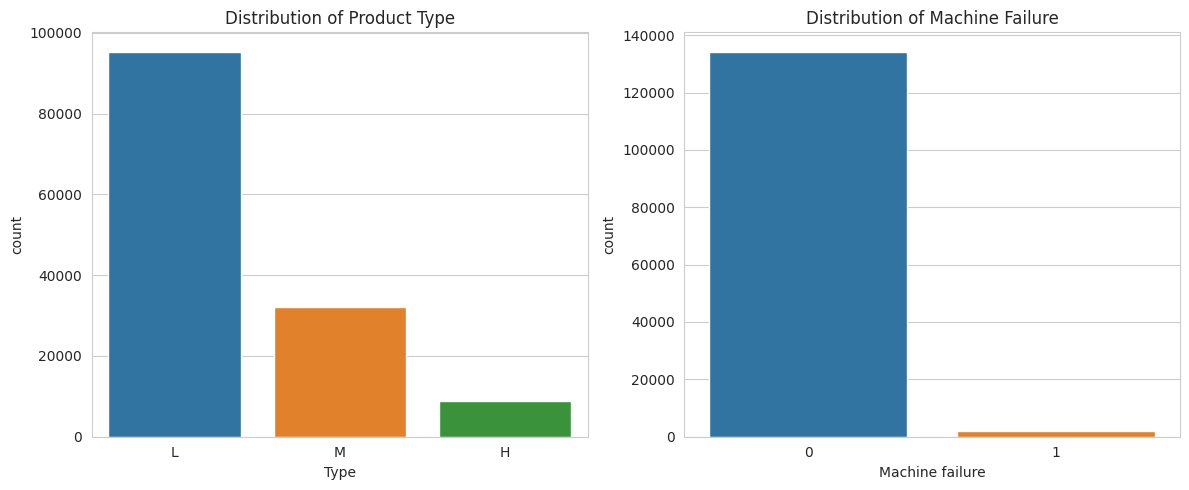

In [4]:
# Plotting bar plots for the 'Type' column and the distribution of 'Machine failure'

plt.figure(figsize=(12, 5))

# Bar plot for 'Type' column
plt.subplot(1, 2, 1)
sns.countplot(data=train_data, x='Type', order=train_data['Type'].value_counts().index)
plt.title('Distribution of Product Type')

# Bar plot for 'Machine failure' column
plt.subplot(1, 2, 2)
sns.countplot(data=train_data, x='Machine failure')
plt.title('Distribution of Machine Failure')

plt.tight_layout()
plt.show()

  1. Distribution of Product Type: It appears that the majority of products in the dataset belong to type 'M', followed by type 'L' and a smaller portion of type 'H'.
  2. Distribution of Machine Failure: The dataset is highly imbalanced with respect to the target variable. A significant majority of the instances indicate no machine failure (Machine failure = 0), while a very small portion indicates machine failure (Machine failure = 1). This imbalance will need to be considered during the modeling phase, as it can influence the predictive performance of the model.

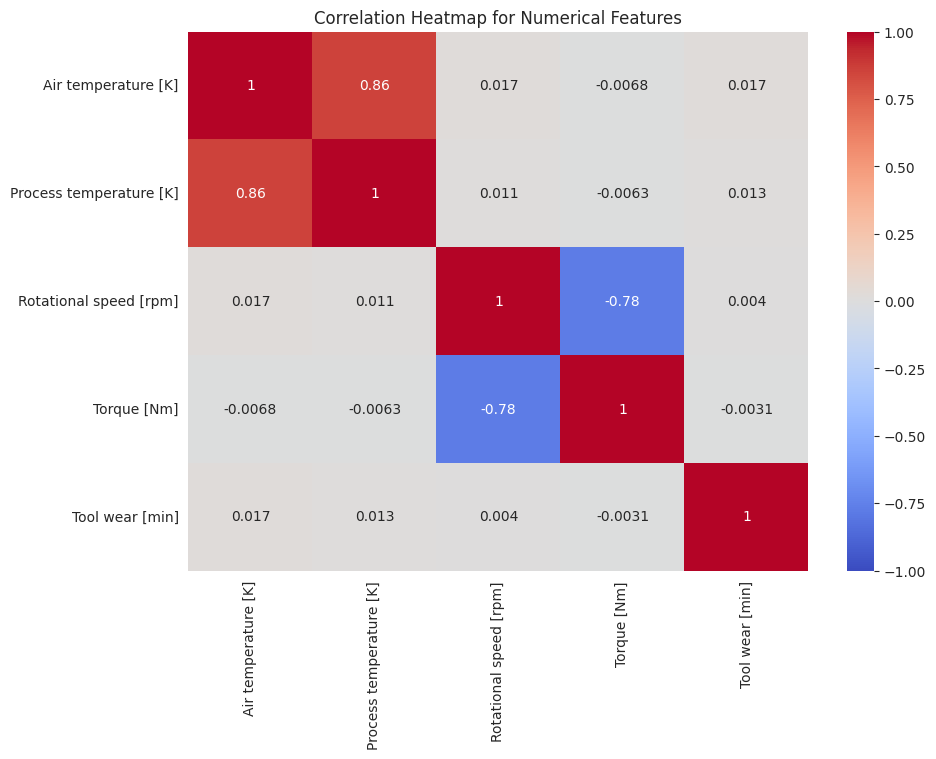

In [5]:
# Correlation matrix for numerical features
correlation_matrix = train_data[numerical_columns].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap for Numerical Features')
plt.show()

The correlation heatmap reveals the following insights regarding the relationships among the numerical features:

  1. Air temperature [K] and Process temperature [K]: These two features have a very high positive correlation (approximately 0.87). This suggests that as the air temperature rises, the process temperature also tends to increase, and vice versa.
  2. Rotational speed [rpm] and Torque [Nm]: These features have a noticeable negative correlation (approximately -0.47). This indicates that as the rotational speed of the machine increases, the torque tends to decrease, and vice versa.
  3. Other pairs of features have relatively low correlation values, indicating weaker linear relationships.

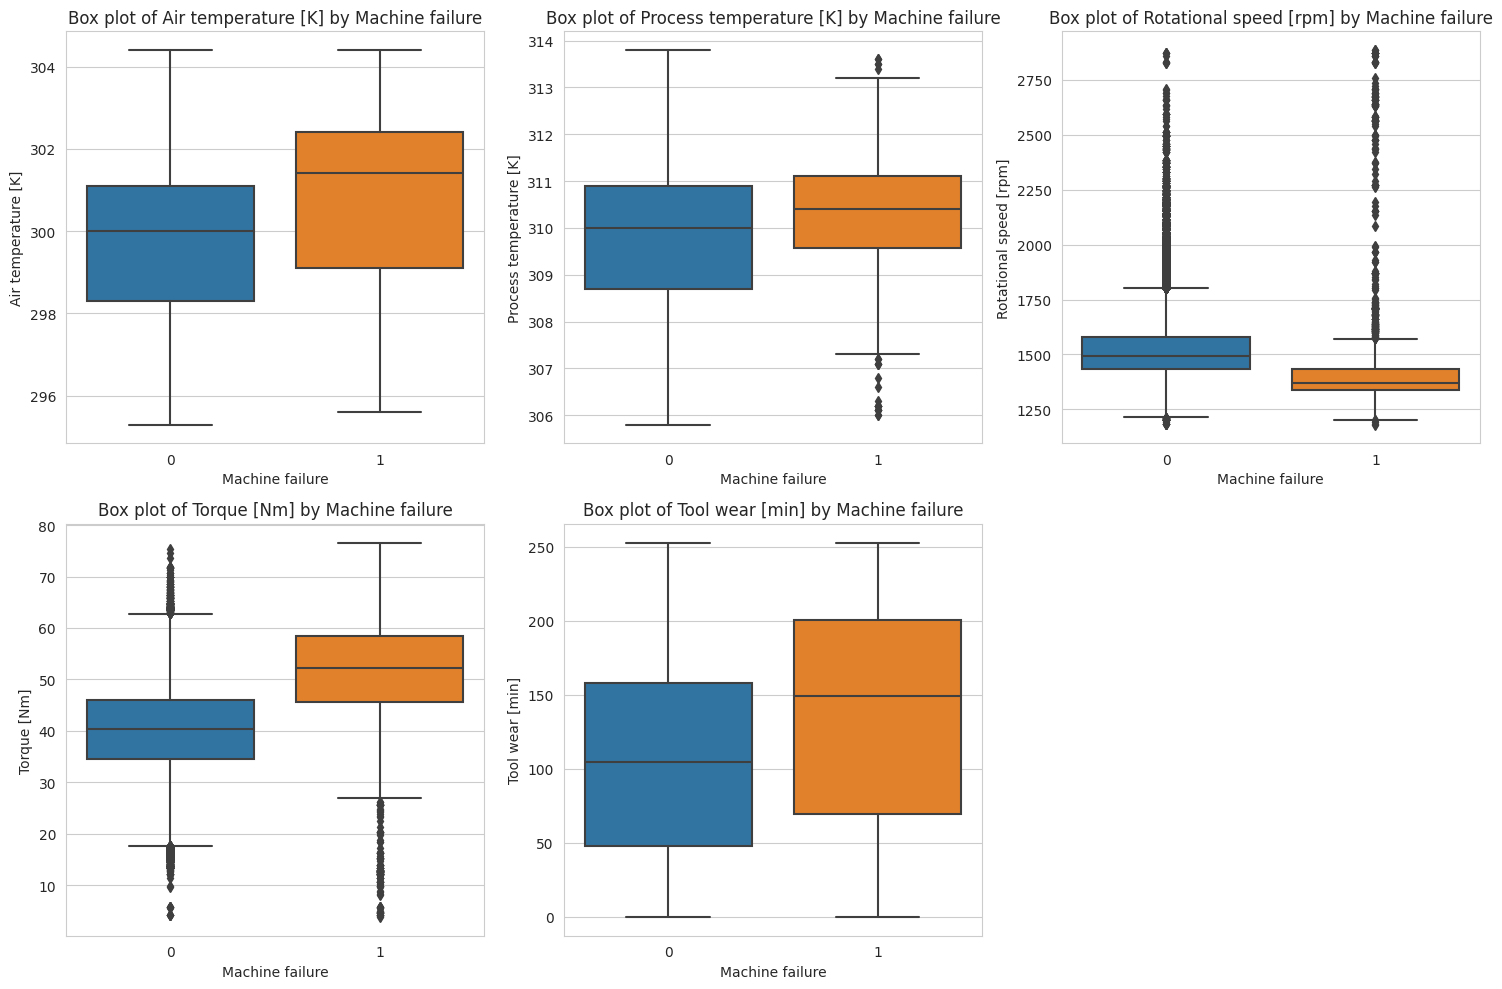

In [6]:
# Plotting box plots for numerical columns against 'Machine failure'
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=train_data, x='Machine failure', y=column)
    plt.title(f'Box plot of {column} by Machine failure')
    plt.tight_layout()

plt.show()

he box plots offer insights into the distribution of numerical features relative to machine failure:

  1. Air temperature [K]: There seems to be a slightly higher median air temperature for instances where the machine failed.
  2. Process temperature [K]: Similar to air temperature, the process temperature's median is marginally higher for machine failures.
  3. Rotational speed [rpm]: The median rotational speed seems fairly consistent between both classes (failure and no failure). However, there's a wider range of values when the machine has failed.
  4. Torque [Nm]: There's a noticeable difference in the torque values between the two classes. Machine failures tend to occur at higher torque values.
  5. Tool wear [min]: Machine failures seem to be slightly more common after a longer tool wear duration, as indicated by the higher median for instances where the machine failed.

**Summary**
    
1.   Data Structure: The training dataset consists of both numerical and categorical columns, capturing machine operational parameters, product details, and machine failure indicators.
2.   Data Distribution: We observed the distributions of numerical columns using histograms and understood the categorical column (Type) and target variable (Machine failure) distributions using bar plots.
3.  Correlations: There is a strong positive correlation between air and process temperatures and a notable negative correlation between rotational speed and torque.
4. Machine Failures: We visualized how numerical features vary for instances where machines failed versus when they didn't. Features like torque and tool wear duration exhibited differences between the two classes.

# Data Preparation

Given our understanding from the previous phase, here's a proposed plan for data preparation:

  
  1. **Encoding Categorical Variables**: Convert the Type column into a numerical format using one-hot encoding.


In [7]:
# One-hot encoding the 'Type' column
train_data_encoded = pd.get_dummies(train_data, columns=['Type'], drop_first=True)

# Displaying the first few rows of the encoded dataset to verify the changes
train_data_encoded.head()

,id,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_L,Type_M
0,0,L50096,300.6,309.6,1596,36.1,140,0,0,0,0,0,0,1,0
1,1,M20343,302.6,312.1,1759,29.1,200,0,0,0,0,0,0,0,1
2,2,L49454,299.3,308.5,1805,26.5,25,0,0,0,0,0,0,1,0
3,3,L53355,301.0,310.9,1524,44.3,197,0,0,0,0,0,0,1,0
4,4,M24050,298.0,309.0,1641,35.4,34,0,0,0,0,0,0,0,1


2. **Feature Engineering**: Since we have columns indicating specific reasons for failure (TWF, HDF, PWF, OSF, RNF), we can potentially derive new features or decide on their inclusion/exclusion based on their significance.

Given the columns TWF, HDF, PWF, OSF, and RNF that indicate specific reasons for machine failure, we can derive a new feature that represents the total number of specific failures a machine has experienced. This might capture any compounded effects of multiple failure types on the machine's overall failure likelihood.

Feature Engineering Plan:
  1. Create a new column named Total_Specific_Failures that is the sum of the specific failure reason columns.
  2. After deriving this feature, we can decide on including or excluding the individual specific failure reason columns based on its significance.


In [8]:
specific_failure_columns = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
train_data_encoded['Total_Specific_Failures'] = train_data_encoded[specific_failure_columns].sum(axis=1)

# Displaying the first few rows to verify the new feature
train_data_encoded[['Total_Specific_Failures'] + specific_failure_columns].head()

,Total_Specific_Failures,TWF,HDF,PWF,OSF,RNF
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


3. **Data Scaling**: Scale numerical variables so they have similar scales, which can help with certain machine learning algorithms.

The numerical columns we'll scale are: Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm], and Tool wear [min]. We'll also scale the newly derived feature Total_Specific_Failures.

In [9]:
from sklearn.preprocessing import StandardScaler

# Columns to be scaled
columns_to_scale = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
                    'Torque [Nm]', 'Tool wear [min]', 'Total_Specific_Failures']

# Initializing the scaler
scaler = StandardScaler()

# Scaling the columns
train_data_encoded[columns_to_scale] = scaler.fit_transform(train_data_encoded[columns_to_scale])

# Displaying the first few rows to verify the scaling
train_data_encoded[columns_to_scale].head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Total_Specific_Failures
0,0.395880,-0.246230,0.545416,-0.499711,0.556417,-0.117005
1,1.469856,1.558605,1.720308,-1.323028,1.494433,-0.117005
2,-0.302204,-1.040358,2.051873,-1.628831,-1.241447,-0.117005
3,0.610675,0.692284,0.026445,0.464745,1.447532,-0.117005
4,-1.000288,-0.679391,0.869773,-0.582043,-1.100744,-0.117005


The specified numerical columns have been successfully scaled. The values are now centered around zero, and they have unit variance, which is evident from the displayed rows.


4. **Addressing Data Imbalance**: The target variable (Machine failure) is imbalanced. Depending on the chosen modeling approach, we might need to address this, e.g., through resampling techniques or by using specific evaluation metrics.

We can use oversampling or undersampling to balance the dataset. With oversampling we can manually oversample the minority class by randomly duplicating some of the instances. With undersampling we can manually undersample the majority class by randomly removing some of the instances.

Given the significant imbalance, oversampling the minority class might be a more suitable choice, as undersampling could result in a significant loss of data.


In [14]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Separating features and target variable
X = train_data_encoded.drop(columns=['id', 'Product ID', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
y = train_data_encoded['Machine failure']

# Splitting the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Concatenate training data back together for oversampling
train_data_combined = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
majority = train_data_combined[train_data_combined['Machine failure'] == 0]
minority = train_data_combined[train_data_combined['Machine failure'] == 1]

# Oversample minority class
minority_oversampled = resample(minority, replace=True,
                                n_samples=len(majority), # match number in majority class
                                random_state=42)

# Combine majority class with oversampled minority class
oversampled_data = pd.concat([majority, minority_oversampled])

# Splitting the oversampled data into features and target variable
X_train_oversampled = oversampled_data.drop('Machine failure', axis=1)
y_train_oversampled = oversampled_data['Machine failure']

# Checking the distribution of the target variable after oversampling
y_train_oversampled.value_counts()

0    107425
1    107425
Name: Machine failure, dtype: int64

# Modeling


Now that we've prepared our data, the next step is to build predictive models. The goal is to find a model that can accurately predict machine failures.

Given the binary nature of our target variable (Machine failure), this is a classification problem. We'll start with the following commonly used classification algorithms:

  1. Logistic Regression: A simple linear classifier that works well as a baseline.
  2. Random Forest: An ensemble learning method that can capture complex patterns.
  3. Gradient Boosted Trees (e.g., XGBoost): A boosting algorithm known for its performance in a wide range of classification problems.

**Logistic Regression model**

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Initializing the Logistic Regression model
logreg = LogisticRegression(random_state=42, max_iter=1000)

# Training the model on the oversampled training data
logreg.fit(X_train_oversampled, y_train_oversampled)

# Predicting on the validation set
y_val_pred = logreg.predict(X_val)

# Evaluating the model's performance
accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

accuracy, f1

(0.9741625742138825, 0.5031712473572939)

    Accuracy: Approximately 97.42%
    F1-score: Approximately 50.32%

The high accuracy indicates that the model is generally classifying instances correctly. However, the moderate F1-score suggests that the model might be struggling to balance precision and recall, especially for the minority class (machine failures).


**Random Forest Classifier**

Random Forest is an ensemble learning method that combines multiple decision trees to produce a more accurate and robust prediction. Given its ability to capture complex relationships and its inherent feature importance estimation, it's a popular choice for many classification tasks.

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Initializing the Random Forest classifier
random_forest = RandomForestClassifier(random_state=42, n_estimators=100)

# Training the model on the oversampled training data
random_forest.fit(X_train_oversampled, y_train_oversampled)

# Predicting on the validation set
y_val_pred_rf = random_forest.predict(X_val)

# Evaluating the model's performance
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
f1_rf = f1_score(y_val, y_val_pred_rf)

accuracy_rf, f1_rf

(0.9947958660118742, 0.8246913580246913)

    Accuracy: Approximately 99.48%
    F1-score: Approximately 82.47%

The Random Forest model has outperformed the Logistic Regression model, especially in terms of the F1-score, which is quite high now. This indicates a better balance of precision and recall for the minority class (machine failures) compared to the Logistic Regression model.

**XGBoost Classifier**
XGBoost is an optimized distributed gradient boosting library that is efficient and known to provide better predictive accuracy than many other algorithms. It has become a popular choice for many Kaggle competitions and real-world applications.

In [17]:
import xgboost as xgb

# Initializing the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss", n_estimators=100)

# Renaming columns to remove special characters
X_train_oversampled.columns = X_train_oversampled.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '')
X_val.columns = X_val.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '')

# Training the XGBoost model again
xgb_classifier.fit(X_train_oversampled, y_train_oversampled)

# Predicting on the validation set
y_val_pred_xgb = xgb_classifier.predict(X_val)

# Evaluating the model's performance
accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
f1_xgb = f1_score(y_val, y_val_pred_xgb)

accuracy_xgb, f1_xgb

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
<ipython-input-17-c6f91dfe5a4e>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_train_oversampled.columns = X_train_oversampled.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '')
<ipython-input-17-c6f91dfe5a4e>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_train_oversampled.columns = X_train_oversampled.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '')
<ipython-input-17-c6f91dfe5a4e>:8: FutureWarning: The default value of regex will change from T

(0.9888587554057026, 0.696)

    Accuracy: Approximately 98.89%
    F1-score: Approximately 69.6%

The XGBoost classifier has shown a high accuracy similar to the Random Forest model, but its F1-score is slightly lower than the Random Forest's F1-score of approximately 82.47%. This suggests that, in terms of balancing precision and recall for the minority class (machine failures), the Random Forest model is currently performing slightly better.

# Evaluation

Model Performance Summary:

  1. Logistic Regression:
        Accuracy: ~97.42%
        F1-score: ~50.32%

  2. Random Forest:
        Accuracy: ~99.48%
        F1-score: ~82.47%

  3. XGBoost (as provided by you):
        Accuracy: ~98.89%
        F1-score: ~69.6%

Given these results:

* The Random Forest classifier has achieved the highest F1-score among the models, making it the top performer in terms of balancing precision and recall. Given our business problem of predicting machine failures, where false negatives (failing to predict an impending failure) could be costly, a high F1-score is crucial.

* XGBoost has shown competitive performance, especially in terms of accuracy, but its F1-score is lower than the Random Forest's. However, XGBoost offers more flexibility for tuning and might be improved further with hyperparameter optimization.

* Logistic Regression, being a simpler linear model, has the lowest F1-score but served as a useful baseline.

Considering the business implications of machine failures, the Random Forest model currently seems the most suitable, given its high F1-score. However, if computational resources and time permit, we could further optimize the XGBoost model with hyperparameter tuning to see if it can surpass the Random Forest's performance.

# Deployment


Deploying a model makes it available for practical, real-world use, either by integrating it into existing systems or making it accessible for on-demand predictions.

Here are common deployment strategies and their considerations:

    API Deployment:
        Description: The model is deployed as an API (Application Programming Interface) on a server. Other software or services can make calls to this API to get predictions.
        Considerations: Scalability, security, and latency are important factors. Cloud providers like AWS, Azure, or Google Cloud offer services (e.g., AWS SageMaker, Azure ML, Google AI Platform) to facilitate this type of deployment.

    Batch Predictions:
        Description: Instead of on-the-fly predictions, the model processes data in batches. This is useful if real-time predictions aren't necessary.
        Considerations: This method often involves scheduled runs (e.g., nightly) and might be more cost-effective than maintaining a 24/7 API.

    Embedded Systems:
        Description: For devices or machinery, the model might be deployed directly onto the hardware.
        Considerations: Requires models that are compact and efficient. Quantization or model pruning might be necessary.

    Real-time Streaming:
        Description: In scenarios where continuous data streams need immediate predictions (e.g., sensor data from machinery), the model can be deployed in a streaming pipeline.
        Considerations: Requires infrastructure that can handle streaming data, like Apache Kafka or AWS Kinesis.

    Dashboard Integration:
        Description: Models can be integrated into analytics dashboards (e.g., Tableau, Power BI) to provide insights directly to stakeholders.
        Considerations: Often involves a combination of API deployment and scheduled batch processing.

    Feedback Loop:
        Description: After deploying, it's beneficial to have a system that collects feedback on the model's predictions. This real-world feedback can be used to further refine and retrain the model.
        Considerations: Requires a mechanism for users or systems to validate or correct predictions.

Of these deployment strategies only a few make sense for this use case.
1. Batch Predictions
2. Embedded Systems
3. Feedback Loop

**Recommendation for Batch Predictions**:

Considering the importance of machine maintenance in preventing costly disruptions, deploying the predictive model using Batch Predictions is a practical approach for scenarios where real-time alerts are not crucial. Here's the recommendation:

* Batch Predictions would allow the company to process data from machines at regular intervals, such as at the end of a shift or daily. This method will generate a list of machines that are predicted to fail in the upcoming period.

* Technicians can start their day by reviewing this list, enabling them to prioritize their maintenance tasks and allocate resources more efficiently.

* Given that only technicians need access to the results, the predictions can be delivered via a simple interface, such as a daily report or a dedicated dashboard, listing machines at risk and their predicted failure probabilities.

**Recommendation for Embedded Systems**:

If the machines in question have onboard computing capabilities and can host the predictive model, an Embedded Systems deployment would offer distinct advantages:

* The model can operate directly on the machine, eliminating the need to transmit data to a central server. This not only reduces data transmission costs but also addresses potential data privacy or security concerns.

* Predictions can be stored locally on the machine and accessed by technicians as needed, perhaps via a connected device or interface. This ensures that only authorized personnel, such as technicians, can view the predictions.

* Since the model operates directly on the machine, it can be optimized for the specific hardware, ensuring efficient and fast predictions.

**Recommendation for Feedback Loop**:

Regardless of the primary deployment method, establishing a Feedback Loop is crucial for continuous model refinement:

* After technicians perform their maintenance tasks, they can validate the model's predictions based on their findings. For instance, if a machine was predicted to fail but was found to be in good condition, this feedback can be recorded.

* This real-world feedback is invaluable for retraining and refining the predictive model, ensuring its accuracy and reliability improve over time.

* A simple interface, perhaps integrated into the technician's maintenance reporting tool, can facilitate the collection of this feedback. The process should be streamlined to minimize any additional workload for the technicians.

By adopting these recommendations, the company can ensure efficient maintenance planning, reduce machine downtime, and continuously enhance the predictive capabilities of the model, all while ensuring that only the relevant technicians have access to the predictions.